# 快速入门

[ReAct Agent](https://docs.langchain.com/oss/python/langchain/agents#tool-use-in-the-react-loop) 是一种将 **推理**（Reasoning）与 **行动**（Acting）结合起来的智能体。它是智能体的核心科技，也是智能体框架中最能表现其自主性的组件。

它的工作流程遵循三步循环：

1. 思考
2. 行动
3. 观察

这个循环会持续进行，直到 LLM 判断任务已经完成或无法继续。

这意味着智能体可以通过工具调用，自动补足当前未知的上下文信息。然后基于新获取的信息，做出下一步决策。比如你要智能体查询一个数据表中的记录，它可能尚不知道数据库中有哪些表，表中有哪些字段。但是通过几轮主动查询与观察，即使你询问的信息比较模糊，它大概率也能从表名和字段中推测出你需要的记录是哪一条。这就是 ReAct Agent 的威力。

本节将介绍：

- 如何创建简单的 ReAct Agent
- 如何创建带工具的 ReAct Agent
- 如何创建带工具权限的 ReAct Agent
- 结构化输出
- 流式输出


## 一、环境配置

### 1）安装依赖

你可以下载 [本仓库](https://github.com/luochang212/dive-into-langgraph) 到本地，然后运行以下命令，安装完整的 Python 依赖：

```bash
cd dive-into-langgraph
pip install -r requirements.txt
```

```{dropdown} 依赖包列表
  以下为 `requirements.txt` 中的依赖包清单：

  - `pydantic`
  - `python-dotenv`
  - `langchain[openai]`
  - `langchain-community`
  - `langchain-mcp-adapters`
  - `langchain-text-splitters`
  - `langgraph`
  - `langgraph-cli[inmem]`
  - `langgraph-supervisor`
  - `langgraph-checkpoint-sqlite`
  - `langgraph-checkpoint-redis`
  - `langmem`
  - `ipynbname`
  - `fastmcp`
  - `bs4`
  - `scikit-learn`
  - `supervisor`
  - `jieba`
  - `dashscope`
  - `tavily-python`
  - `ddgs`

```

或者，你也可以直接安装 LangGraph，遇到缺少的依赖再行安装：

```bash
pip install langgraph langchain
```

### 2）导入依赖

使用 .env.example 创建 .env 文件:

```bash
cp .env.example .env
```

> PS: 本教程使用阿里百炼平台的模型。你需要在 [阿里百炼平台](https://www.aliyun.com/product/bailian) 注册账号，并将获得的 API 密钥填入 .env 文件中的 `DASHSCOPE_API_KEY` 变量。

In [1]:
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain.agents import create_agent
from langchain.chat_models import init_chat_model

# 加载模型配置
# 请事先在 .env 中配置 DASHSCOPE_API_KEY
_ = load_dotenv()

### 3）加载 LLM

下面是两种加载大模型的方法，任选一种就行：

In [2]:
# 方法一：使用 ChatOpenAI 加载 LLM
llm = ChatOpenAI(
    model="qwen3-coder-plus",
    api_key=os.getenv("DASHSCOPE_API_KEY"),
    base_url=os.getenv("DASHSCOPE_BASE_URL"),
)

# 方法二：使用 init_chat_model 加载 LLM
llm = init_chat_model(
    model="qwen3-coder-plus",
    model_provider="openai",  # Qwen 兼容 OpenAI API
    api_key=os.getenv("DASHSCOPE_API_KEY"),
    base_url=os.getenv("DASHSCOPE_BASE_URL"),
)

## 二、简单的 Agent

首先，创建一个最简单的 ReAct Agent。

In [3]:
# 创建一个简单的Agent
agent = create_agent(
    model=llm,
    system_prompt="You are a helpful assistant",
)

# 运行Agent
response = agent.invoke({'messages': '你好'})

response['messages'][-1].content

'你好！有什么我可以帮助你的吗？'

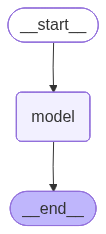

In [4]:
# 可视化 Agent
agent

## 三、带工具调用的 Agent

接下来，我们创建一个带工具调用的 ReAct Agent，它会根据需求自主决定是否调用工具。

In [5]:
# 一个工具函数
def get_weather(city: str) -> str:
    """Get weather for a given city."""
    return f"It's always sunny in {city}!"

# 创建带工具调用的Agent
tool_agent = create_agent(
    model=llm,
    tools=[get_weather],
    system_prompt="You are a helpful assistant",
)

# 运行Agent
response = tool_agent.invoke(
    {"messages": [{"role": "user", "content": "what is the weather in sf"}]}
)

response['messages'][-1].content

"It's always sunny in sf!"

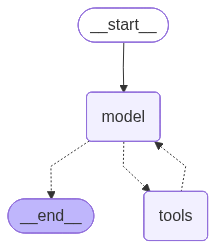

In [6]:
# 可视化 Agent
tool_agent

## 四、使用 `ToolRuntime` 控制工具权限

下面创建一个带 runtime 的工具，runtime 类型为 ToolRuntime。当我们调用 Agent 时，会将这个 runtime 传递给工具。工具再根据 runtime 中的信息，判断当前调用是否具备执行权限。

In [7]:
from typing import Literal, Any
from pydantic import BaseModel
from langchain.tools import tool, ToolRuntime

class Context(BaseModel):
    authority: Literal["admin", "user"]

# 创建带权限控制的tool，依赖ToolRuntime的内容进行判断
@tool
def math_add(runtime: ToolRuntime[Context, Any], a: int, b: int) -> int:
    """Add two numbers together."""
    authority = runtime.context.authority
    # 只有admin用户可以访问加法工具
    if authority != "admin":
        raise PermissionError("User does not have permission to add numbers")
    return a + b

# 创建带工具调用的Agent
tool_agent = create_agent(
    model=llm,
    tools=[get_weather, math_add],
    system_prompt="You are a helpful assistant",
)

# 在运行Agent时注入context
response = tool_agent.invoke(
    {"messages": [{"role": "user", "content": "请计算 8234783 + 94123832 = ?"}]},
    config={"configurable": {"thread_id": "1"}},
    context=Context(authority="admin"),
)

In [8]:
for message in response['messages']:
    message.pretty_print()

================================ Human Message =================================

请计算 8234783 + 94123832 = ?
================================== Ai Message ==================================
Tool Calls:
  math_add (call_54fadc2161144760af5a829b)
 Call ID: call_54fadc2161144760af5a829b
  Args:
    a: 8234783
    b: 94123832
================================= Tool Message =================================
Name: math_add

102358615
================================== Ai Message ==================================

8234783 + 94123832 = 102358615


In [9]:
# 验证计算结果是否正确
8234783 + 94123832

102358615

## 五、结构化输出

若想获得结构化输出（Structured Output），可以在 create_agent 函数的 response_format 参数进行设定。在下面的例子中，我们用 BaseModel 定义输出格式，然后在 response_format 中指定该格式。

In [10]:
from pydantic import BaseModel, Field

class CalcInfo(BaseModel):
    """Calculation information."""
    output: int = Field(description="The calculation result")

In [11]:
# 创建带结构化输出的Agent
structured_agent = create_agent(
    model=llm,
    tools=[get_weather, math_add],
    system_prompt="You are a helpful assistant",
    response_format=CalcInfo,
)

response = structured_agent.invoke(
    {"messages": [{"role": "user", "content": "请计算 8234783 + 94123832 = ?"}]},
    config={"configurable": {"thread_id": "1"}},
    context=Context(authority="admin"),
)

In [12]:
for message in response['messages']:
    message.pretty_print()

================================ Human Message =================================

请计算 8234783 + 94123832 = ?
================================== Ai Message ==================================
Tool Calls:
  math_add (call_4fedae02ce8941d2ba75e15e)
 Call ID: call_4fedae02ce8941d2ba75e15e
  Args:
    a: 8234783
    b: 94123832
================================= Tool Message =================================
Name: math_add

102358615
================================== Ai Message ==================================
Tool Calls:
  CalcInfo (call_093119ef93f947e9b40caeda)
 Call ID: call_093119ef93f947e9b40caeda
  Args:
    output: 102358615
================================= Tool Message =================================
Name: CalcInfo

Returning structured response: output=102358615


In [13]:
response['messages'][-1]

ToolMessage(content='Returning structured response: output=102358615', name='CalcInfo', id='41c39e89-f3dc-4a14-99e5-3fc420b7014b', tool_call_id='call_093119ef93f947e9b40caeda')

## 六、流式输出

下面是一个简单的例子，更多信息请参阅 [streaming](https://docs.langchain.com/oss/python/langchain/streaming).

In [14]:
agent = create_agent(
    model=llm,
    tools=[get_weather],
)

for chunk in agent.stream(  
    {"messages": [{"role": "user", "content": "What is the weather in SF?"}]},
    stream_mode="updates",
):
    for step, data in chunk.items():
        print(f"step: {step}")
        print(f"content: {data['messages'][-1].content_blocks}")

step: model
content: [{'type': 'tool_call', 'name': 'get_weather', 'args': {'city': 'SF'}, 'id': 'call_0c9b494066ba4b6eb9c85d7c'}]
step: tools
content: [{'type': 'text', 'text': "It's always sunny in SF!"}]
step: model
content: [{'type': 'text', 'text': "It's always sunny in SF!"}]
